# Seq2Seq 기계 번역

이번 프로젝트에선 임의로 Seq2Seq 모델을 아주 간단화 시켰습니다.
한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌
영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델을 같이 구현해 보겠습니다.

In [1]:
import numpy as np
import torch as th
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
'''
미니 GRU 모델.
'''
class Seq2Seq_GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq_GRU, self).__init__()

        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size * 2, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder inputs and states
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        outputs = []

        decoder_state = encoder_state
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(targets)[i].view(1,-1, self.hidden_size)
            decoder_input = th.cat((decoder_input, encoder_state), 2)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)#.unsqueeze(0))
            outputs.append(projection)
            
            #_, top_i = prediction.data.topk(1)
            
        outputs = th.stack(outputs, 1).squeeze()

        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_()) 



In [5]:
model = Seq2Seq_GRU(vocab_size, 16)
pred = model(x, y)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
y_.append(3)
y_label = Variable(th.LongTensor(y_[1:]))

In [8]:
print(y_label.shape)
print(y_label)

torch.Size([4])
tensor([111, 108,  97,   3])


In [9]:
log = []
for i in range(10000):
    prediction = model(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()

0 loss: 5.712370872497559
] , , å 
100 loss: 2.0981945991516113
h o l a 
200 loss: 0.6704353094100952
h o l a 
300 loss: 0.3248082399368286
h o l a 
400 loss: 0.18652379512786865
h o l a 
500 loss: 0.11785173416137695
h o l a 
600 loss: 0.08392083644866943
h o l a 
700 loss: 0.06378734111785889
h o l a 
800 loss: 0.05056416988372803
h o l a 
900 loss: 0.041283249855041504
h o l a 
1000 loss: 0.0344545841217041
h o l a 
1100 loss: 0.02924966812133789
h o l a 
1200 loss: 0.025171399116516113
h o l a 
1300 loss: 0.021904587745666504
h o l a 
1400 loss: 0.01923954486846924
h o l a 
1500 loss: 0.01703178882598877
h o l a 
1600 loss: 0.015179157257080078
h o l a 
1700 loss: 0.013607501983642578
h o l a 
1800 loss: 0.012260913848876953
h o l a 
1900 loss: 0.011096715927124023
h o l a 
2000 loss: 0.010083198547363281
h o l a 
2100 loss: 0.009195327758789062
h o l a 
2200 loss: 0.008411884307861328
h o l a 
2300 loss: 0.007717609405517578
h o l a 
2400 loss: 0.0070989131927490234
h o l a 
2500 

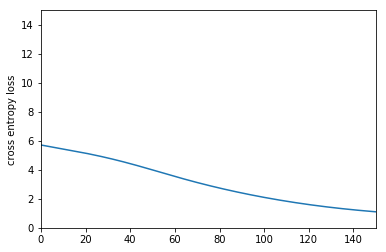

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log)
plt.xlim(0,150)
plt.ylim(0,15)
plt.ylabel('cross entropy loss')
plt.show()
